In [57]:
%pylab inline
import numpy as np
import pandas as pd
import pylab as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
sns.set(style='whitegrid')

Populating the interactive namespace from numpy and matplotlib


Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевой переменной — расстояние от объекта до точки (0, 0).

In [3]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

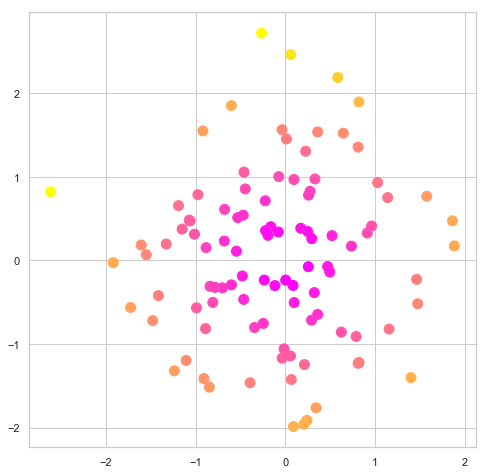

In [4]:
np.random.seed(42)
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5 # 
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

In [7]:
from sklearn.tree import DecisionTreeRegressor

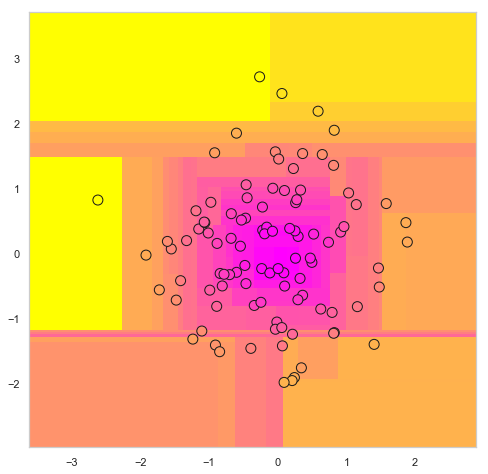

In [8]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

Посмотрим как будет выглядить разделение плоскости в зависимости от

- минимального количества объектов в листе
- максимальной глубины дерева


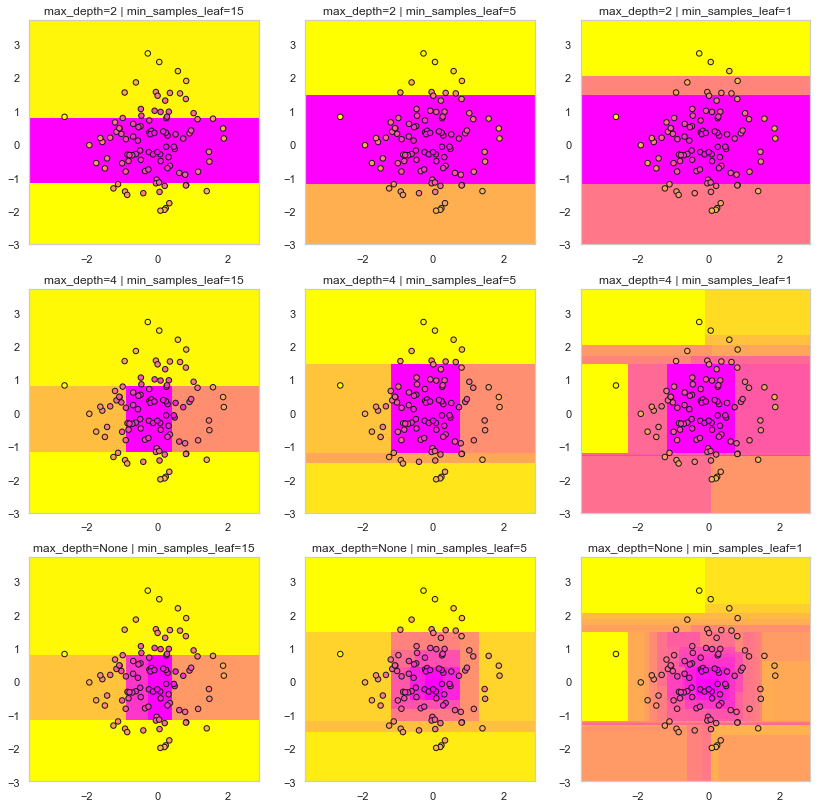

In [9]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

Библиотека для наглядной визуализации деревьев:

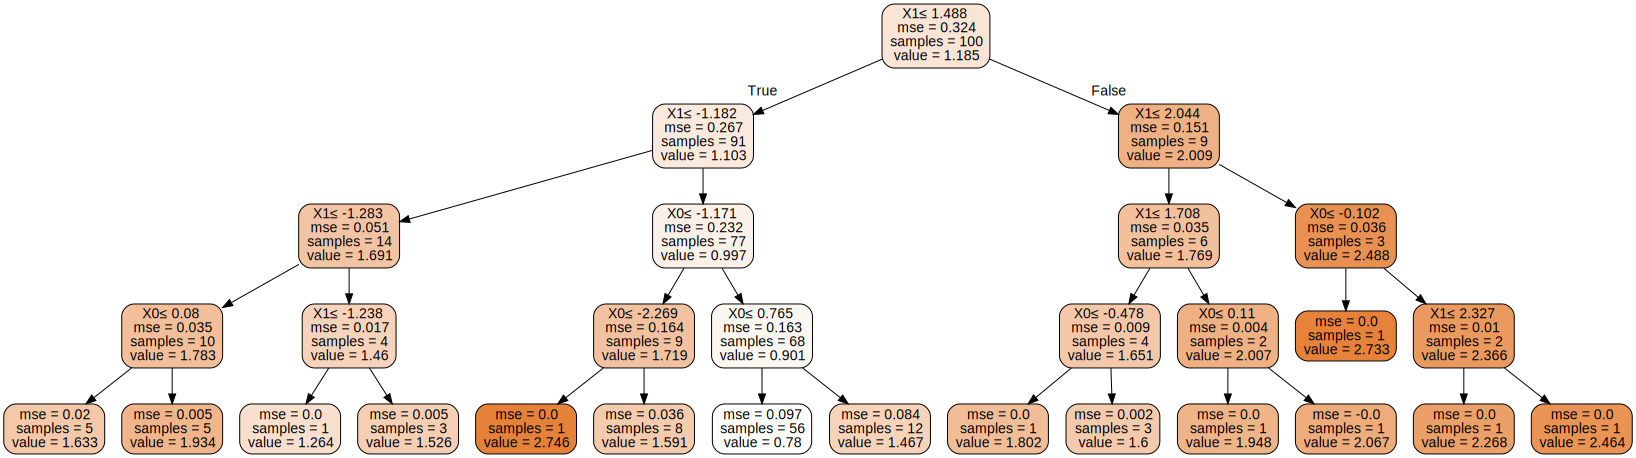

In [10]:
# conda install python-graphviz

import graphviz
from sklearn import tree

clf = DecisionTreeRegressor(max_depth=4)
clf.fit(data_x, data_y)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

dot_data = tree.export_graphviz(clf, out_file=None, 
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться. Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.

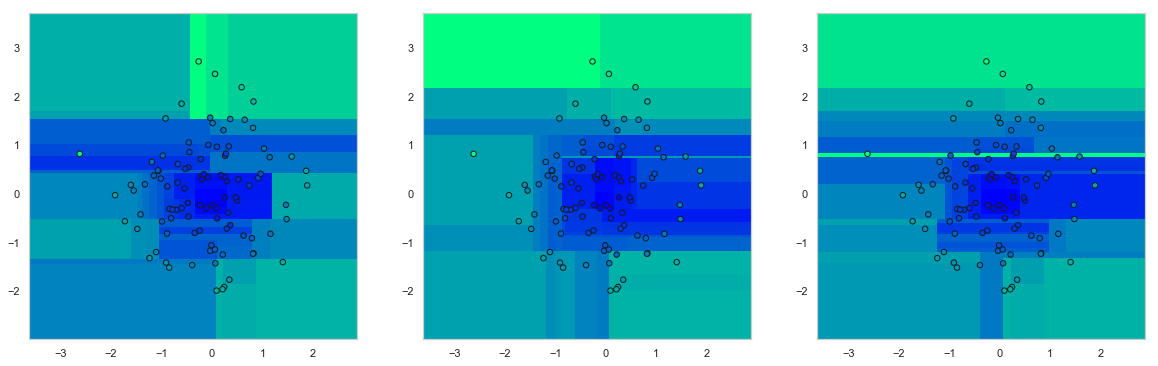

In [11]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

# Decision Tree

Посмотрим на качество дерева в зависимости от параметров на Бостонском датасете.

In [12]:
data = pd.read_csv('./boston_train_data.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [16]:
y = data.medv
data.drop(columns=['medv'], inplace=True)

Кросс-валидация:

In [17]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(shuffle=True, random_state=42)

In [19]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(random_state=42)
-cross_val_score(regr, data, y, cv=cv, scoring='neg_mean_squared_error').mean()

28.234892389902342

In [23]:
cross_val_score(regr, data, y, cv=cv, scoring='r2').mean()

0.5963557276624188

In [25]:
-cross_val_score(regr, data, y, cv=cv, scoring='neg_mean_absolute_error').mean()

3.3430864197530865

### Задание 1:

Посмотрите, какие гиперпараметры есть у модели DecisionTreeRegressor и реализуйте подбор гиперпараметров:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [ ]:
from sklearn.model_selection import GridSearchCV

hyperparameters = # место для Вашего кода
gs = GridSearchCV(regr, , hyperparameters, cv=5, verbose=0) 
best_model = gs.fit(data, target)

Лучшая модель:

In [ ]:
best_model

Параметры лучшей модели:

In [ ]:
best_model.best_estimator_.get_params()

Делаем датасет с параметрами всех моделей:

In [ ]:
cv_grid = pd.DataFrame(gs.cv_results_['params'])

cv_grid['mean_test_score'] = gs.cv_results_['mean_test_score']
cv_grid.head()

Зависимость качества от максимальной глубины:

In [ ]:
sns.catplot(x='max_depth', y='mean_test_score', data=cv_grid,
            col='min_samples_leaf', hue='max_features',
            kind='point')

Нарисуем полученное дерево:

In [ ]:
regr = # Ваша модель
regr.fit(data, y)


dot_data = tree.export_graphviz(regr, out_file=None, feature_names=data.columns,
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Feature importance%

In [ ]:
list(zip(regr.feature_importances_, data.columns))

### Задание 2:

Разбейте целевую переменную на 2-3 примерно равных по количеству объектов класса. Обучите на данных DecisionTreeClassifier:
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Повторите все проделанные прежде шаги: подберите гиперпараметры, посмотрите feature importance полученной модели, нарисуйте ее.

## Random Forest

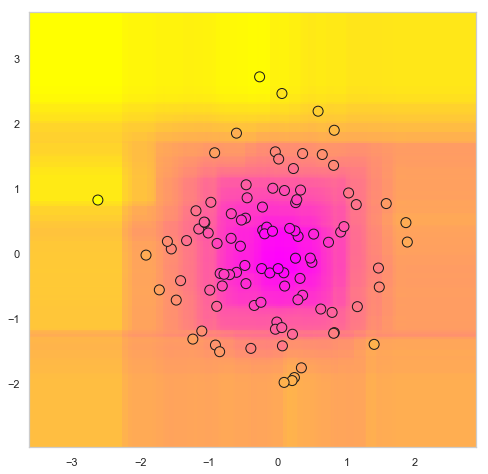

In [52]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

In [53]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=10)
print(cross_val_score(regr, data, y, cv=cv,
                      scoring='r2').mean())

0.759623696018112


In [55]:
regr = RandomForestRegressor(n_estimators=100)
print(cross_val_score(regr, data, y, cv=cv,
                      scoring='r2').mean())

0.8040538965353079


100%|██████████| 38/38 [00:21<00:00,  1.75it/s]


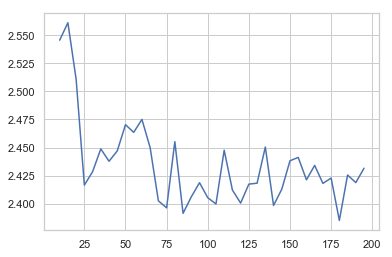

In [59]:
scores = []

for i in tqdm(range(10, 200, 5)):
    regr = RandomForestRegressor(n_estimators=i)
    scores.append(-cross_val_score(regr, data, y, cv=cv,scoring='neg_mean_absolute_error').mean())
    
    
plt.plot(range(10, 200, 5), scores)

## Задание 3:

Подебрите параметры для модели RandomForestRegressor:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html